(Global_Interpretability)=
# Global Interpretability

In this section, let us imagine that we want to go deeper into explaining a model than the two feature importance measures introduced in the previous section. 

The methods explained in this section will be more verbose than the previous ones which just provide an overall importance value per feature. However, we do not want to jump directly to local interpreters, we still discuss some global interpreter methods first.

Two similar methods are covered here: Both are model-agnostic, post-hoc interpreters and focus on one visual explanation per feature:

1. The partial dependence plot (PDP),     
2. The accumulated local effect plot (ALE).

Both allow visualizing, by a plot, the relationship between the output of the prediction model and one or two feature(s) of this model. Focusing on the prediction of a model with respect to one feature produces a 2D plot, and focusing on the prediction of a model with respect to two features produces 3D plots. Therefore, these approaches are difficult to apply to more than two features. 

Before getting to the two methods and putting them into practice in turn, let $\hat{f}(x)$ be the output of the model we want to explain. The set of - one or two - features we want to focus on will be called $X_S$, and the rest of the features will be called $X_C$. Consequently, $X_S$ combined with $X_C$ gives the total feature space $X$. 

## The partial dependence plot (PDP)

The aim of the partial dependence plot is to understand how a feature impacts the outcome of a machine learning model.

Partial dependence plots (PDP) show the dependence between the target response and a set of input features of interest, marginalizing over the values of all other input features (the ‘complement’ features)".

This means that PDPs illustrate how the target variable (the outcome we are trying to predict) changes with respect to certain input features, while averaging out the effects of all other features in the dataset.

A way of picturing it, is to keep the feature under study (e.g. TX_AMOUNT) fixed and impute all the others with the median or mode over all observations.

As an example:

![les9_the_partial_dependency_plot](img/les9_the_partial_dependency_plot.png)

The trained machine learning model is then used to predict (in our example: whether or not a transaction is fraudulent) on the new dataset. 

Then plot the predicted probalilities for the values of the feature under study (e.g. TX_AMOUNT) .

Interation effects might not show up in a PDP.

But, a PDP could be used to detect interaction effects: we could compare patterns which we observe in the data, with the PDP of the combined variables. 

Ivm churn prediction: stel dat de kans op churning in de leeftijdscategorie 30-40 daalt (lager is dan in de omliggende leeftijdscategorieën), en dat de PDP toont dat de kans op churning constant is over de verschillende leeftijdscategorieën, dan duidt dat op een interactie met andere features.

Je kan dus ook meerdere features combineren (zoals bij permutation based feature importance). Visualisatiemethoden zijn bv contour of 3d plots.

The partial dependence plot simply averages the predictions over the marginal distribution of the training data. In other words, partial dependence works by marginalizing $\hat{f}$ over the distribution of the features set $C$, so that the function shows the relationship between the feature(s) in set $S$ and the predicted outcome {cite}`molnar2019`.


Before discussing the other method, ALE, let us use PDP to explain the same random forest model as in the previous section.

In [1]:
# Initialization: Load shared functions and simulated data 

# Load shared functions
!curl -O https://raw.githubusercontent.com/Fraud-Detection-Handbook/fraud-detection-handbook/main/Chapter_References/shared_functions.py
%run shared_functions.py

# Get simulated data from Github repository
if not os.path.exists("simulated-data-transformed"):
    !git clone https://github.com/Fraud-Detection-Handbook/simulated-data-transformed

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 63257  100 63257    0     0   181k      0 --:--:-- --:--:-- --:--:--  181k


In [6]:
import numpy as np
import pandas as pd
import timeit
import pickle
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

%run shared_functions.py

# Load data from the 2018-07-25 to the 2018-08-14
DIR_INPUT='./simulated-data-transformed/data/' 

BEGIN_DATE = "2018-07-25"
END_DATE = "2018-09-26"

print("Load  files")
%time transactions_df=read_from_files(DIR_INPUT, BEGIN_DATE, END_DATE)
print("{0} transactions loaded, containing {1} fraudulent transactions".format(len(transactions_df),transactions_df.TX_FRAUD.sum()))

# Training period
start_date_training = datetime.datetime.strptime("2018-07-25", "%Y-%m-%d")
end_date_training = datetime.datetime.strptime("2018-07-31", "%Y-%m-%d")

# Delay period
start_date_delay = datetime.datetime.strptime("2018-08-01", "%Y-%m-%d")
end_date_delay = datetime.datetime.strptime("2018-08-07", "%Y-%m-%d")

# Test period
start_date_test = datetime.datetime.strptime("2018-08-08", "%Y-%m-%d")
end_date_test = datetime.datetime.strptime("2018-08-15", "%Y-%m-%d")

# Get the corresponding data
train = transactions_df[transactions_df.TX_DATETIME<end_date_training]
delay = transactions_df[transactions_df.TX_DATETIME>start_date_delay]
delay =           delay[transactions_df.TX_DATETIME<end_date_delay] 
test = transactions_df[transactions_df.TX_DATETIME>start_date_test]

# Build classifier
clf = RandomForestClassifier(random_state=0)

input_features = ['TX_AMOUNT', 'TX_DURING_NIGHT', 'CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW', 'CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW']
input_features_small = ['AMOUNT', 'NIGHT', 'AVA1D', 'AVA30D']
output_feature = "TX_FRAUD"

# Train classifier
model_and_predictions_dictionary = fit_model_and_get_predictions(clf, train, test, 
                                                                 input_features, output_feature, scale=False)

test['predictions']=model_and_predictions_dictionary['predictions_test']
    
performance_assessment(test, top_k_list=[50])

Load  files
CPU times: user 194 ms, sys: 287 ms, total: 481 ms
Wall time: 1.53 s
613550 transactions loaded, containing 5500 fraudulent transactions


,AUC ROC,Average precision,Card Precision@50
0,0.665,0.303,0.154


In [3]:
#Changing the plot parameter for later
plt.rcParams['figure.figsize'] = [30, 12]

Let us use the PDP on the model we just trained. Sklearn provides an implementation for PDP:
`PartialDependenceDisplay` which requires a model (`estimator`), the training samples (`X`), and `features` is the list of features we want to plot, in turn, for set $S$. Finally, tuple of size 2 can be used for 3D PDP, but we will use the 2D version first.

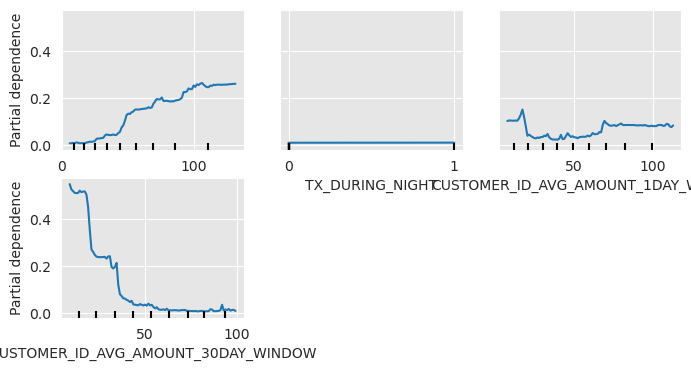

In [9]:
from sklearn.inspection import PartialDependenceDisplay
pdp = PartialDependenceDisplay.from_estimator(clf, X=train[input_features], features=input_features)

plt.rcParams['figure.figsize'] = [30, 12]
plt.rcParams.update({'font.size': 15})

Each plot of the PDP shows the relation between the output of the random forest (genuine is zero, and fraud is one) and a particular feature. It seems that no features can really bring the output of the random forest to predict frauds. Remember that PDP displays the overall global effect and that the dataset is strongly unbalanced. It can be more meaningful to check the model behavior for fraud only, or re-balance the plot. In practice, It can also be meaningful to focus on certain clusters of transactions. Notice that the black bars are here to report the 10 quantiles of the data distribution: the area near the extreme quantiles should be considered unreliable. 

(1032, 23)


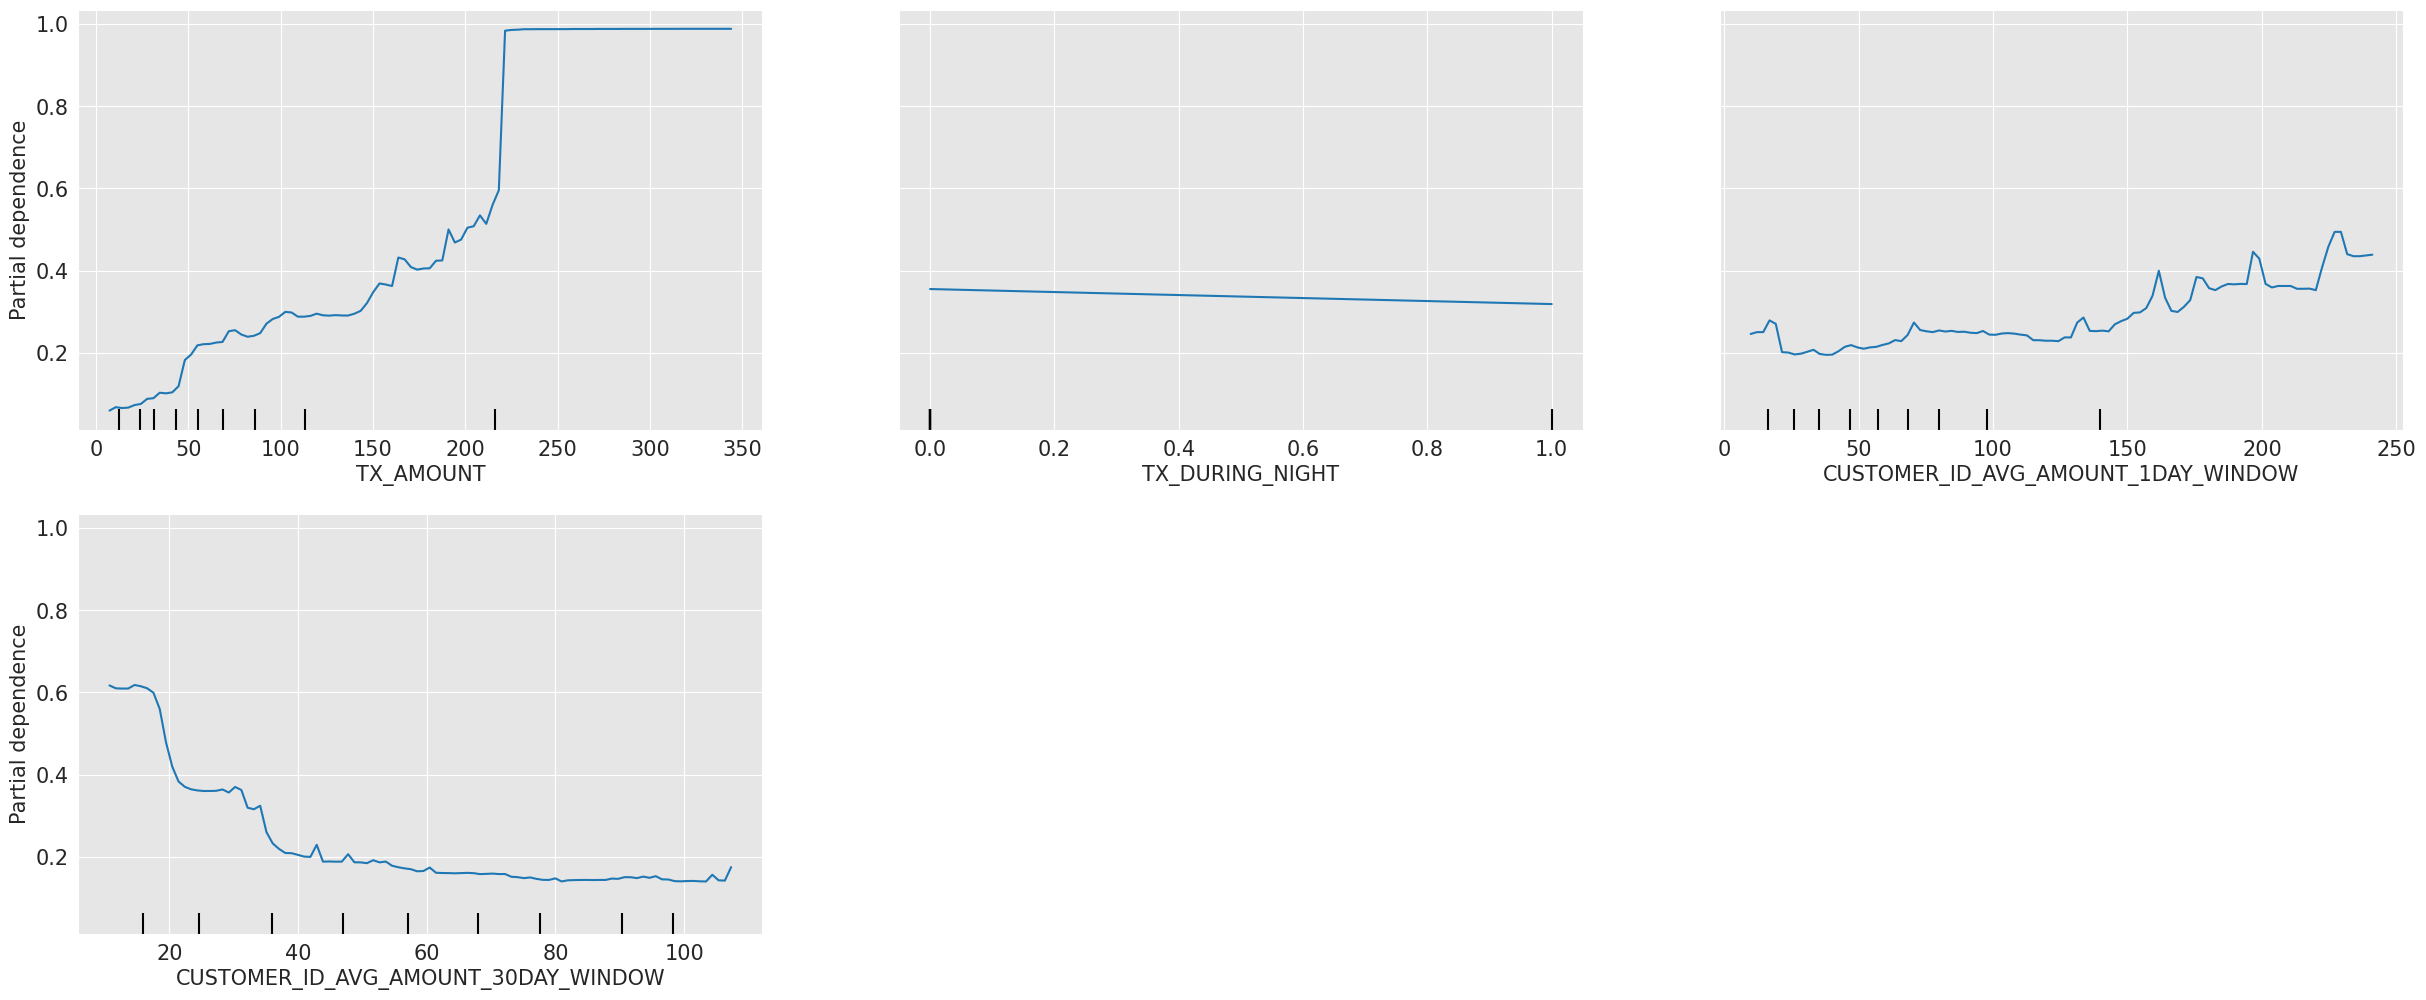

In [10]:
# separate training frauds and genuines
train1 = train[train.TX_FRAUD==1] # frauds only
train0 = train[train.TX_FRAUD==0] # genuines only
train01 = pd.concat([train1, train0.sample(train1.shape[0])], axis=0) # a re-balanced set obtained by random undersampling
print(train01.shape)

# now we restart with frauds only
pdp = PartialDependenceDisplay.from_estimator(clf, X=train01[input_features], features=input_features)
plt.rcParams['figure.figsize'] = [30, 12]
plt.rcParams.update({'font.size': 15})

This is more clear now, when we plot the PDP for a balanced subdataset! The main discriminative feature is `TX_AMOUNT`. As in the previous section, scenario 1 can be clearly spotted on the `TX_AMOUNT` PDP. 

We see that the prediction of the `TX_DURING_NIGHT` feature is more or less constant between it's two possible values, 0 and 1.This feature is useless in practice (remember that here, the data is balanced). 

From inspecting the `CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW` PDP, the lower the value of the feature, the higher the probability of the transaction to be a fraud. Actually, from scenario 2, frauds can be detected if `CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW` is small and `TX_AMOUNT` is high. 

Can PDP spot this behavior? I.e. can it spot the interaction effects between TX_AMOUNT and CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW. The answer is yes.

Remark that from interpreting the PDPs for each of the features separately, we would not now there is a relevant interation between the variables TX_AMOUNT and CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW.

To detect interaction effects, we can contrast patterns observed in the data with a partial dependence plot.

With PDPs, it is possible to keep more than one feature as is,  whilst replacing the others with their median and mode. Note however that this is harder to visualize.
Popular visualization methods are contour and 3d plots. This quickly becomes infeasible for higher dimensions.

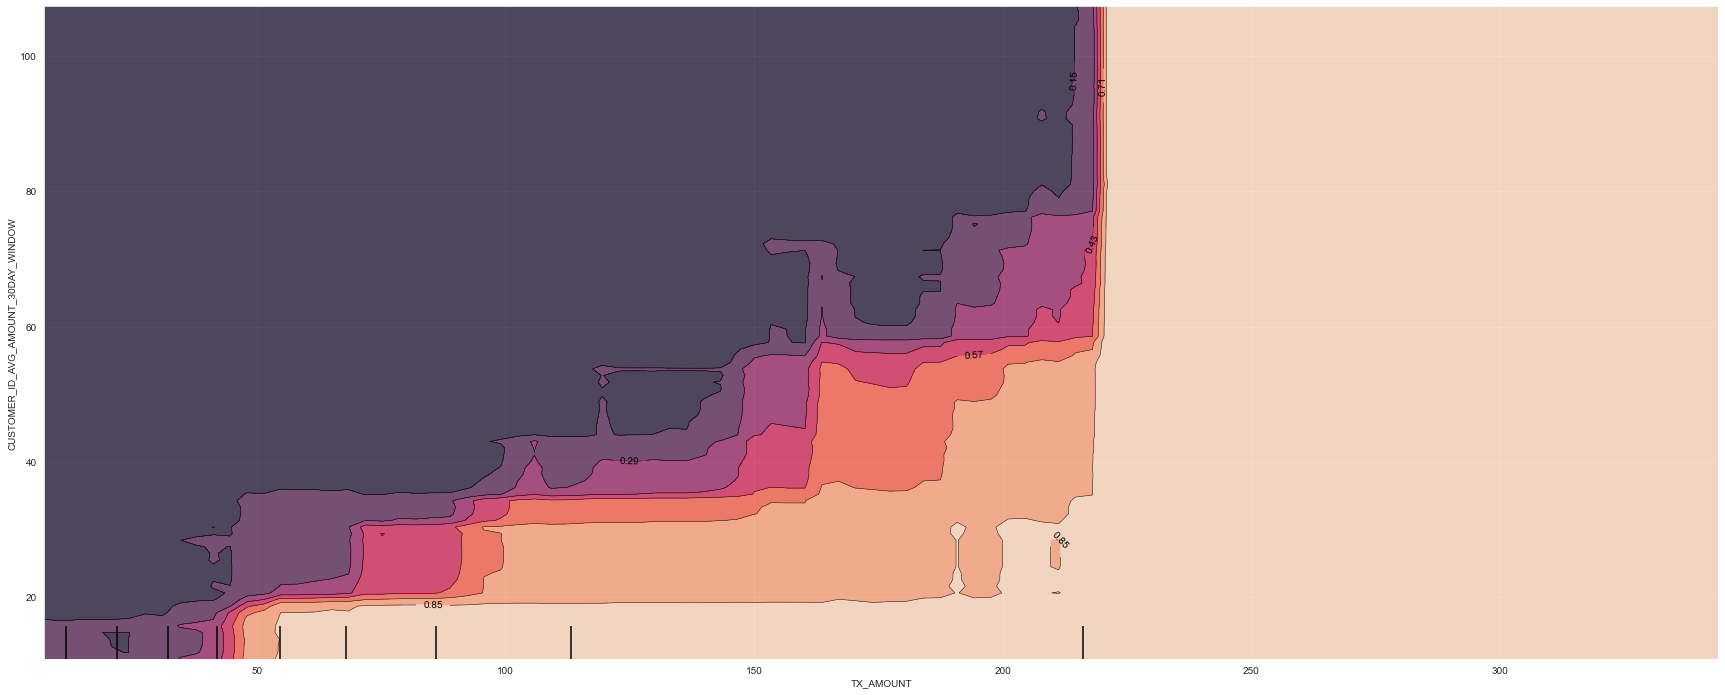

In [6]:
# Providing a pair of feature leads to a 3D version of PDP (here as a 2D contour plot)
pdp = PartialDependenceDisplay.from_estimator(clf, X=train01[input_features], features=[(0,3)])
plt.rcParams['figure.figsize'] = [20, 12]
plt.rcParams.update({'font.size': 15})

The 3D version of PDP can be used. In the previous plot $X_S = $\{`TX_AMOUNT`, `CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW`$\}$ (i.e., `features=[(0,3)]`) is shown. Scenario 1 is reflected by the high output value for `TX_AMOUNT`$>220$ and Scenario 2 can be spotted by comparing `TX_AMOUNT` and `CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW`: the frauds occur when the `TX_AMOUNT` is larger than the `CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW` (at least when `TX_AMOUNT`$<220$).

Normally, `CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW` should also have the same kind of behavior. Let us check this hypothesis.

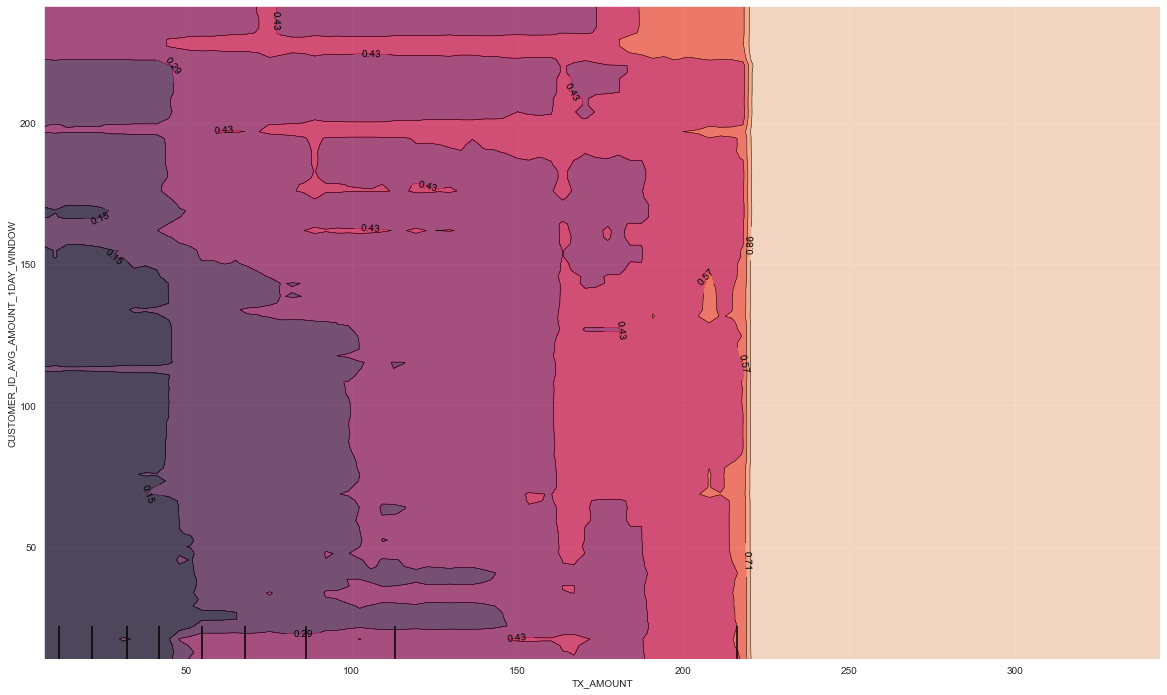

In [7]:
# Providing a pair of features leads to a 3D version of PDP (here as a 2D contour plot)
pdp = PartialDependenceDisplay.from_estimator(clf, X=train01[input_features], features=[(0,2)])
plt.rcParams['figure.figsize'] = [20, 12]
plt.rcParams.update({'font.size': 15})

Our hypothesis seems to be incorrect! An important assumption of the PDP is that the features in set $C$ are not correlated with the features in set $S$. 

In other words: when working with PDPs, it is assumed that the input features of interest are independent from the complement features. This assumption is often violated in practice.

PDPs (i.e. partial dependence plots) work by averaging out the effects of other model inputs. So they should not be used if your variable interacts strongly with other inputs. While you can use multiway PDPs to specify interactions, you would need to specify the interactions up front. PDPs plots will not automatically discover the interactions for you.

The problem is that in fraud detection, the aggregated features are really likely to be correlated. For example, the Pearson correlation between feature `CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW` and `CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW` is around 0.87 for the time period used as an example in this book. This kind of high correlation is obtained by construction because of the overlapping time windows used for our aggregates. 

On the other hand, these multiple time windows are a key asset for better fraud detection. 

In practice, this means that using PDP can be unreliable because its key assumption was broken. **If correlated features are present, ALE should be used instead**.

Where does this problem come from? The rest of this section explains where this problem comes from.

Let us make a toy example for PDP (with **F1** as $X_S$):

| F1  | F2  | F3  |  Y  |
|:---:|:---:|:---:|:---:|
| $x_{11}$ | $x_{12}$ | $x_{13}$ |  $\hat{y_{1}}$ |
| $x_{21}$ | $x_{22}$ | $x_{23}$ |  $\hat{y_{2}}$ |
| $x_{31}$ | $x_{32}$ | $x_{33}$ |  $\hat{y_{3}}$ |

To produce the PDP, the algorithm first makes copies of the samples, duplicating the full dataset for each possible value of **F1** (Notice that the predictions according to the model were updated).

| F1  | F2  | F3  |  Y  |
|:---:|:---:|:---:|:---:|
| $x_{11}$ | $x_{12}$ | $x_{13}$ |  $\hat{y_{11}}$ |
| $x_{11}$ | $x_{22}$ | $x_{23}$ |  $\hat{y_{12}}$ |
| $x_{11}$ | $x_{32}$ | $x_{33}$ |  $\hat{y_{13}}$ |
| $x_{21}$ | $x_{12}$ | $x_{13}$ |  $\hat{y_{21}}$ |
| $x_{21}$ | $x_{22}$ | $x_{23}$ |  $\hat{y_{22}}$ |
| $x_{21}$ | $x_{32}$ | $x_{33}$ |  $\hat{y_{23}}$ |
| $x_{31}$ | $x_{12}$ | $x_{13}$ |  $\hat{y_{31}}$ |
| $x_{31}$ | $x_{22}$ | $x_{23}$ |  $\hat{y_{32}}$ |
| $x_{31}$ | $x_{32}$ | $x_{33}$ |  $\hat{y_{33}}$ |

PDP displays only one curve: $[x_{11},x_{21},x_{31}]$ on the x-axis and $[\frac{\hat{y_{11}}+\hat{y_{12}}+\hat{y_{13}}}{3},\frac{\hat{y_{21}}+\hat{y_{22}}+\hat{y_{23}}}{3},\frac{\hat{y_{31}}+\hat{y_{32}}+\hat{y_{33}}}{3}]$ on the y-axis.


When the features are correlated, PDP is likely to create new data points which have absolutely no sense ('absurd data points'). Imagine for example that a new transaction with `CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW` = 100 and `CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW` = 0. This means the subsequent estimation is then polluted by unrealistic samples. Therefore, the PDP estimation for correlated features can be unreliable.

## The accumulated local effect plot

There were some efforts to circumvent the problem of correlated variables in PDP. ALE plots were developed as an attempt to obtain an unbiased alternative to PDP. The main difference is that PDP average over the marginal distribution where ALE will use the conditional distribution. Let us first replace the marginal distribution with the conditional distribution in the first PDP equation (this step is sometimes called M-plots):

$$
\hat{f}_{x_S,\text{M}}(x_S) = E_{X_C | X_S} [ \hat{f}(X_S,X_C) | X_S = x_s] = 
\int_{ x_C } \hat{f}(x_S,x_C) \text{P}(x_C | x_S) d x_C 
$$

Because conditional distributions are used, unlikely instances will disappear from the expected value in the M-Plots computation. A second step is to remove the effect of all correlated features on a considered feature. To do so, ALE computes differences in predictions instead of averaging directly. Let us take an example: For the effect of `TX_AMOUNT` equal to 200, ALE will use all transactions with an amount around 200 (depending on the size of a chosen grid) and subtract:
- $(a)$ the model prediction, changing the amount of these transactions to 220 

- $(b)$ the model prediction, changing the amount of these transactions to 180. 

$(a)-(b)$ gives us the pure effect of the transaction amount and is not mixing the effect with the effects of correlated features. ALE uses such differences to prevent the effect of other correlated features. It is also how it is implemented in practice.

Now that the foundations of ALE are reviewed, it will be used in a practical illustration. Sklearn does not currently support ALE, so the PyALE package is used instead. The parameters are roughly the same as for PDP, but we also need to specify the `feature_type` and `grid_size`. Both are used during the computation of the densities from the ALE equation. 

As ALE is a global method and the dataset is unbalanced, interpreting using the full data can be misleading. The same balanced set of transactions as in the PDP part is therefore used. ALE also provides a confidence interval for the curve using bootstrapping.

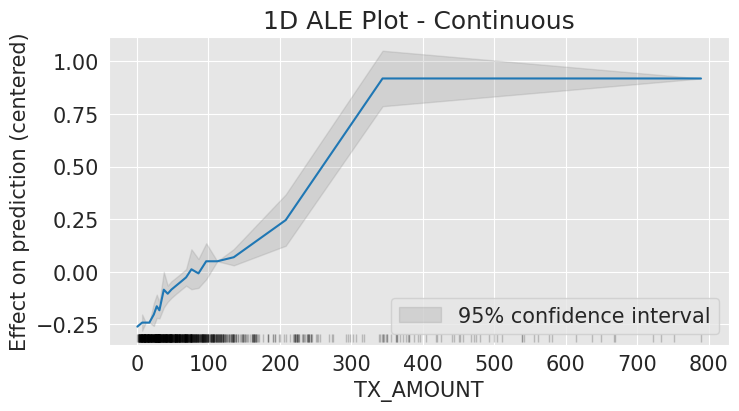

In [11]:
# ! pip install PyALE
#Changing the plot size
plt.rcParams['figure.figsize'] = [8, 4]

from PyALE import ale
ale_eff_1D_AM = ale(X=train01[input_features], model=clf, feature=['TX_AMOUNT'], feature_type='continuous', grid_size=20, include_CI=True)

Recall that ALE is centered, and that the y-axis can change according to `grid_size`. Apart from that, we have a similar behavior with PDP.

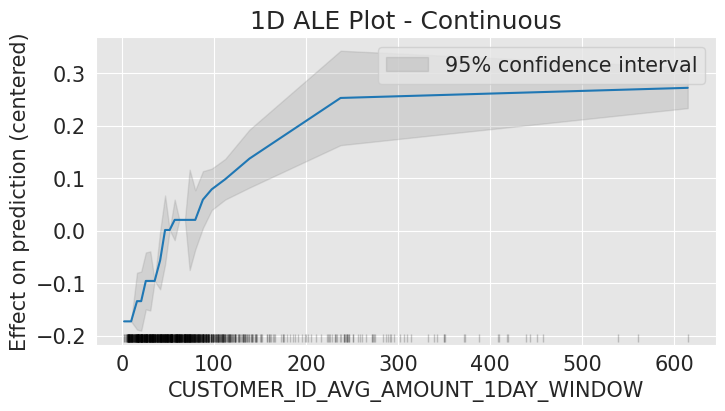

In [12]:
ale_eff_1D_1D = ale(X=train01[input_features], model=clf, feature=['CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW'], feature_type='continuous', grid_size=20)
# This one is the opposite of PDP (flat line)

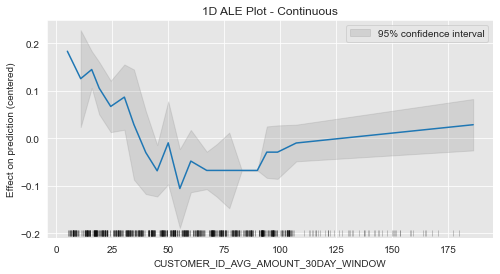

In [10]:
ale_eff_1D_30D = ale(X=train01[input_features], model=clf, feature=['CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW'], feature_type='continuous', grid_size=20)
# This one is the opposite of PDP (flat line)

In [11]:
plt.rcParams['figure.figsize'] = [30, 12]

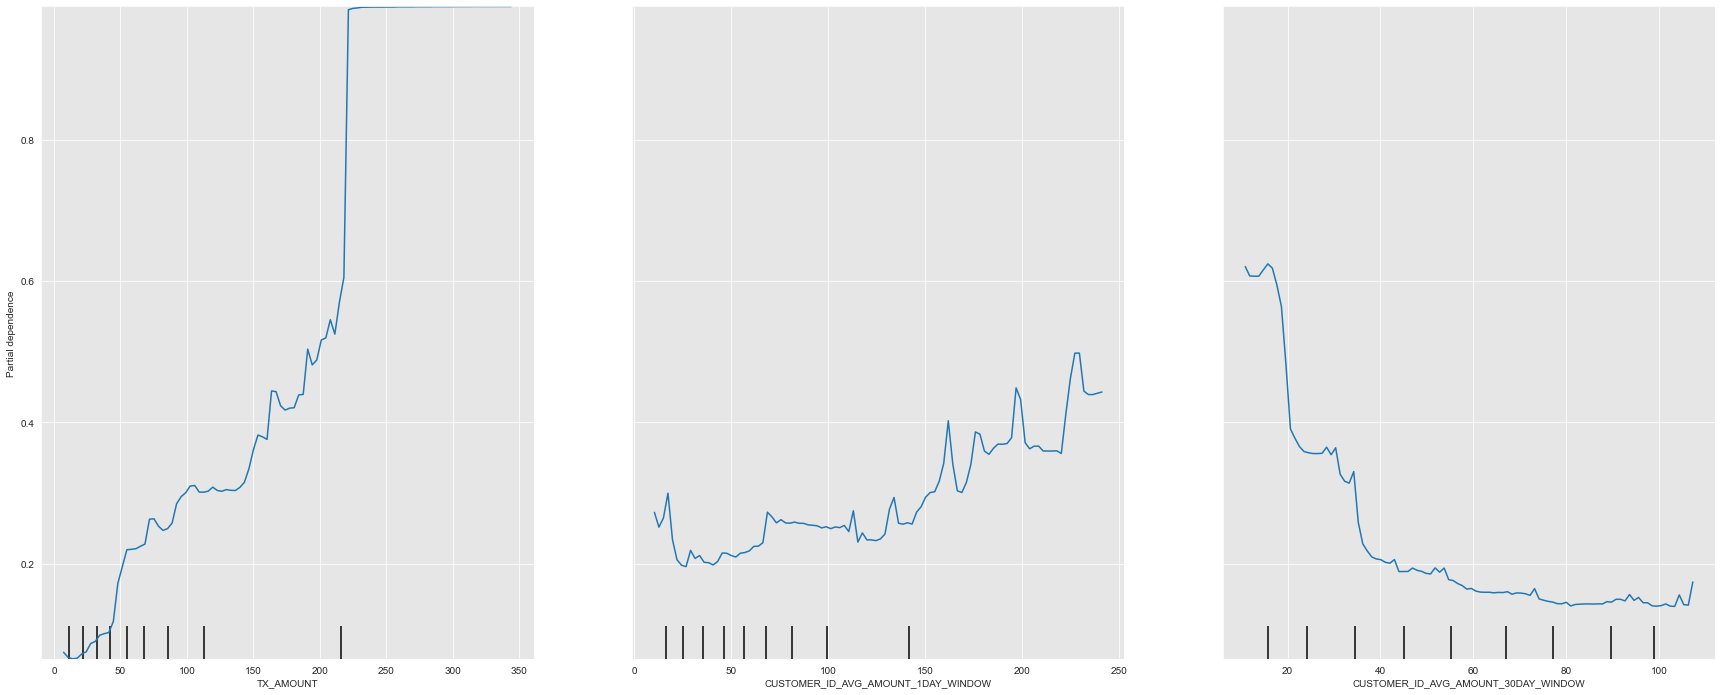

In [12]:
# replot PDP, for easy comparison
pdp = PartialDependenceDisplay.from_estimator(clf, X=train01[input_features], features=[0,2,3])
plt.rcParams['figure.figsize'] = [30, 12]
plt.rcParams.update({'font.size': 30})

PDP and ALE go in the same direction. We can therefore put more trust in our explanations